# Tutorial: 3-Bus Unit Commitment

### This is a very small example adapted from the paper: "Accelerating the Benders decomposition for network-constrained unit commitment problems", by Lei Wu and Mohamma Shahidehpour, 
### Energy Systems (2010): DOI 10.1007/s12667-010-0015-4

#### A 3-bus system shown in figure below with three generators, three transmission lines, and one load is studied. 
#### Three generators are located at three buses respectively, with parameters listed in Table 5. Transmission line capacities are also given in the figure. Reactance of all lines is 0.1 p.u. and bus 1 is the reference bus.
#### A one-hour NCUC problem is described as follows, where is considered to ﬁnd the optimal UC decisions and generation dispatch with minimum operation cost, while satisfying the system load of 450 MW located at bus 3. For this one-hour case study, other constraints, such as reserve requirement, system losses, generator minimum on/off time constraints, and ramping up/down limits, are relaxed for the sake of discussion. 
#### The problem is formulated as follows with constraints in each row representing the system load balance, generation capacity limits for each unit, power balance for each bus, dc power ﬂow equation for each transmission line, power ﬂow capacity limits for each line, and the reference bus identiﬁcation

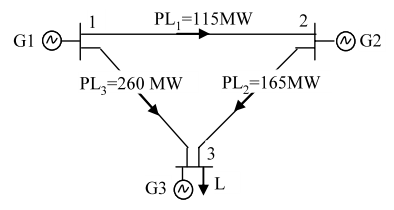

### Generator Data

| Generator | $P^{\min}$ (MW) | $P^{\max}$ (MW) | Cost function (\$/MWh) |
|-----------|-------------------|-------------------|------------------------|
| 1         | 100               | 500               | 10                     |
| 2         | 90                | 400               | 11                     |
| 3         | 30                | 200               | 12                     |


### Optimization problem

$$\min \; 10 \cdot P_{11} \;+\; 11 \cdot P_{21} \;+\; 12 \cdot P_{31}$$

**s.t.:**

\begin{aligned}
& P_{11} + P_{21} + P_{31} = 450,\\[6pt]
& 100 \cdot I_{11} \;\le\; P_{11} \;\le\; 500 \cdot I_{11},\\
& 90 \cdot I_{21} \;\le\; P_{21} \;\le\; 400 \cdot I_{21},\\
& 30 \cdot I_{31} \;\le\; P_{31} \;\le\; 200 \cdot I_{31},\\[6pt]
& PL_{11} + PL_{31} = P_{11},\\
& PL_{21} - PL_{11} = P_{21},\\
& -PL_{21} - PL_{31} = P_{31} - 450, \\[6pt]
& PL_{11} - \frac{\theta_{11} - \theta_{21}}{0.1} = 0, \\[6pt]
& PL_{21} - \frac{\theta_{21} - \theta_{31}}{0.1} = 0, \\[6pt]
& PL_{31} - \frac{\theta_{11} - \theta_{31}}{0.1} = 0, \\[6pt]
& -115 \;\le\; PL_{11} \;\le\; 115, \\[6pt]
& -165 \;\le\; PL_{21} \;\le\; 165, \\[6pt]
& -260 \;\le\; PL_{31} \;\le\; 260, \\[6pt]
& \theta_{11} = 0, \\[6pt]
& I_{11}, I_{21}, I_{31} \in \{0,1\}.
\end{aligned}



### headers

In [1]:
using JuMP, HiGHS, MathOptInterface
using Plots
import MathOptInterface
const MOI = MathOptInterface;

### full model

In [2]:
pglim = [[100, 90, 30], [500, 400, 200]];
pllim = [115,165,260];
pgcost = [10,11,12];

solver = "HiGHS";
model=Model(HiGHS.Optimizer)

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [3]:
# setting some attributes
# https://ergo-code.github.io/HiGHS/dev/options/definitions/

set_attribute(model, "output_flag", true)
set_attribute(model, "mip_abs_gap", 1e-4)
set_attribute(model, "presolve", "on")
set_attribute(model, "time_limit", 60.0)
set_attribute(model, "solver", "choose")
set_attribute(model, "parallel", "choose")

In [4]:
# variables
pg = @variable(model, [i=1:3], base_name="P"); #in paper/model, this variable name is P
u = @variable(model, [i=1:3], base_name="u", Bin); #in paper/model, this variable name is I
pl = @variable(model, [i=1:3], base_name="pl");
θ = @variable(model, [i=1:3], base_name="θ");

# constraints
@constraint(model, sum(pg[i] for i in 1:3) == 450);
@constraint(model, [i=1:3], pglim[1][i]*u[i] <= pg[i]);
@constraint(model, [i=1:3], pg[i] <= pglim[2][i]*u[i]);
@constraint(model, pl[1] + pl[3] == pg[1]);
@constraint(model, pl[2] - pl[1] == pg[2]);
@constraint(model, -pl[2] - pl[3] == pg[3] - 450);
@constraint(model, pl[1] - (θ[1] - θ[2])/0.1 == 0);
@constraint(model, pl[2] - (θ[2] - θ[3])/0.1 == 0);
@constraint(model, pl[3] - (θ[1] - θ[3])/0.1 == 0);
@constraint(model, [i=1:3], -pllim[i] <= pl[i] <= pllim[i]);
@constraint(model, θ[1] == 0);

#objective
@objective(model, Min, sum(pgcost[i]*pg[i] for i in 1:3));

# # use this part only if this code is inside a function
# model[:pg] = pg;
# model[:u] = u;
# model[:pl] = pl;
# model[:θ] = θ;

In [5]:
# optimize
optimize!(model)

Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 5e+02]
  Cost   [1e+01, 1e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+02, 4e+02]
Presolving model
13 rows, 11 cols, 31 nonzeros  0s
7 rows, 6 cols, 21 nonzeros  0s
7 rows, 4 cols, 17 nonzeros  0s
5 rows, 4 cols, 13 nonzeros  0s
5 rows, 4 cols, 13 nonzeros  0s

Solving MIP model with:
   5 rows
   4 cols (1 binary, 0 integer, 0 implied int., 3 continuous)
   13 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Con

In [6]:
println("Solve Time: $(MOI.get(model, MOI.SolveTimeSec())); Optimal Cost: $(objective_value(model)); MIPGap: $(MOI.get(model, MOI.RelativeGap())*100)");

Solve Time: 0.0018663406372070312; Optimal Cost: 4680.0; MIPGap: 0.0


In [7]:
println("Results:")
for i in 1:3
    println("PG[$i] = ", value(pg[i]))
end

for i in 1:3
    println("U[$i] = ", value(u[i]))
end

for i in 1:3
    println("PL[$i] = ", value(pl[i]))
end

for i in 1:3
    println("θ[$i] = ", value(θ[i]))
end

Results:
PG[1] = 315.0
PG[2] = 90.0
PG[3] = 45.0
U[1] = 1.0
U[2] = 1.0
U[3] = 1.0
PL[1] = 75.0
PL[2] = 165.0
PL[3] = 240.0
θ[1] = 0.0
θ[2] = -7.5
θ[3] = -24.0


### Now we are converting this problem into a

$$
\min \; c^T x
$$
$$
\text{s.t.: }Ax = b
$$
$$
x \in \mathbb{R} \cup \mathbb{Z}
$$

## 1. Defining Variables

We define the decision vector \( x \) as the concatenation of:

- **Original variables:**
  - **Power Generation:**
    - $ pg_{gt} $ for $ t = 1 ; g = 1, 2, 3 $.
  - **Line Power Flows:**
    - $ pl_{lt} $ for $ t = 1 ; l = 1, 2, 3 $.
  - **Voltage Angles:**
    - $ \theta_{bt} $ for $ t = 1; b = 1, 2, 3 $, with $ \theta_{11} = 0 $ as reference bus.
  - **On/Off status of generators:**
    - $ u_{gt} \in \{0,1\} $ for $ t = 1; g = 1, 2, 3 $.
   
We are emphasizing the index $t$ for time, even though the problem has a single period.

- **Slack variables (to convert inequalities into equalities):**

  **a) Generation Limits:**

  For each generator $ g $:
  
  - **Slack associated with lower inequality**  
    $ pg_{gt} \ge P_{gmin} \, u_{gt} $  
    → defining $ s_{gt}^L \ge 0 $ such that  
    $
    pg_{gt} - P_{gmin} \, u_{gt} - s_{gt}^L = 0.
    $

  - **Slack associated with upper inequality**  
    $ pg_{gt} \le P_{gmax} \, u_{gt} $  
    → defining $ s_{gt}^U \ge 0 $ such that  
    $
    P_{gmax} \, u_{gt} - pg_{gt} - s_{gt}^U = 0.
    $

  **b) Flow limits:**

  For each line $ l $ (with limit $ pl_{l}^{lim} $), we have
  $
  -pl_{l}^{lim} \le p_{lt} \le pl_{l}^{lim}.
  $

  A standard way to “equalize” these inequalities is to separate the two sides:
  
  - For the inequality $ pl_{lt} \le pl_{l}^{lim} $, we introduce $ s_{lt}^+ \ge 0 $ with
    $
    pl_{l}^{lim} - pl_{lt} - s_{lt}^+ = 0.
    $
  
  - For the inequality $ -pl_{lt} \le pl_{l}^{lim} $ (equivalent to $ pl_{lt} \ge -pl_{l}^{lim} $), we introduce $ s_{lt}^- \ge 0 $ with
    $
    pl_{lt} + pl_{l}^{lim} - s_{lt}^- = 0.
    $


# Order of Variables

A possible ordering of the vector $ x $ (total dimension 24, 21 continuous and 3 integers) is

$
x = \begin{bmatrix}
pg_{1} \\
pg_{2} \\
pg_{3} \\
pl_{1} \\
pl_{2} \\
pl_{3} \\
\theta_1 \\
\theta_2 \\
\theta_3 \\
u_1 \\
u_2 \\
u_3 \\
s^L_1 \\
s^L_2 \\
s^L_3 \\
s^U_1 \\
s^U_2 \\
s^U_3 \\
s^+_1 \\
s^+_2 \\
s^+_3 \\
s^-_1 \\
s^-_2 \\
s^-_3
\end{bmatrix}
$

In the following equations, the indices refer to the position in $ x $ according to this order. For example:

- **Positions 1–3:** $ pg_{gt} $ for $ t = 1; g = 1, 2, 3 $.
- **Positions 4–6:** $ pl_{lt} $ for $ t = 1; l = 1, 2, 3 $.
- **Positions 7–9:** $ \theta_{bt} $ for $ t = 1; b = 1, 2, 3 $.
- **Positions 10–12:** $ u_{gt} $ for $ t = 1; g = 1, 2, 3 $.
- **Positions 13–15:** $ s^L_{gt} $ for $ t = 1; g = 1, 2, 3 $.
- **Positions 16–18:** $ s^U_{gt} $ for $ t = 1; g = 1, 2, 3 $.
- **Positions 19–21:** $ s_{lt}^+ $ for $ t = 1; l = 1, 2, 3 $.
- **Positions 22–24:** $ s_{lt}^- $ for $ t = 1; l = 1, 2, 3 $.

We omit the index $t$ for simplicity.


# 2. Problem Data

**Demand:**
- $ D = 450 $.

**Generation Costs:**
- $ c = [10,\, 11,\, 12] $ for generators 1, 2 and 3, respectively.

**Generation Limits:**
- $ P_{\min} = [100,\, 90,\, 30] $,
- $ P_{\max} = [500,\, 400,\, 200] $.

**Flow Limits:**
- $ p_{l}^{lim} = [115,\, 165,\, 260] $.

**DC Approximation:**
- The relation between flows and angles are:

  $
  p_{l1} = \frac{\theta_1 - \theta_2}{0.1}, \quad
  p_{l2} = \frac{\theta_2 - \theta_3}{0.1}, \quad
  p_{l3} = \frac{\theta_1 - \theta_3}{0.1}.
  $
- Equivalently, multiplying both sides by 0.1:

  $
  p_{l1} - 10 (\theta_1 - \theta_2) = 0, \quad
  p_{l2} - 10 (\theta_2 - \theta_3) = 0, \quad
  p_{l3} - 10 (\theta_1 - \theta_3) = 0.
  $

**Other relations (power balance):**
- The equations that relate the $ p_{gi} $ with $ p_{li} $ are:

  $
  \begin{aligned}
  p_{l1} + p_{l3} &= p_{g1}, \\
  p_{l2} - p_{l1} &= p_{g2}, \\
  -p_{l2} - p_{l3} &= p_{g3} - D.
  \end{aligned}
  $

**Reference Bus:**
- $ \theta_1 = 0 $.


# 3. Specification of Equations (Ax = b)

Next, we enumerate the linear equations (each corresponding to a line of $ A $).

---

## (I) Demand fulfillment

**(1)**
$
pg_{1} + pg_{2} + pg_{3} = 450.
$

- **Line 1 of $ A $:**  
  - **Coefficients:** $[1,\, 1,\, 1,\, 0, \dots, 0]$ 
  - **$ b_1 = 450 $**

---

## (II) Generator Limits Constraints

For each $ g \in \{1,2,3\} $:

### (2.1) Lower limit:
$
pg_{g} - P_{gmin} \, u_g - s^L_g = 0.
$

- **Example for $ g = 1 $ (line 2):**
  - **Coefficient in $ pg_{1} $:** $1$
  - **Coefficient in $ u_1 $** (position 10): $-100$  
    (because $ P_{gmin}(1) = 100 $)
  - **Coefficient in $ s^L_1 $** (position 13): $-1$
  - **Other coefficients:** $0$
  - **$ b = 0 $** for this line.

### (2.2) Upper limit:
$
P_{gmax} \, u_g - pg_{g} - s^U_g = 0.
$

- **Example for $ g = 1 $ (line 5):**
  - **Coefficient in $ u_1 $:** $500$  
    (because $ P_{gmax}(1) = 500 $)
  - **Coefficient in $ p_{g1} $:** $-1$
  - **Coefficient in $ s^U_1 $** (position 16): $-1$
  - **Other coefficients:** $0$
  - **$ b = 0 $** for this line.

---

Thus, we will have three lines for the lower bounds (lines 2–4) and three lines for the upper bounds (lines 5–7).


## (III) Power Balance Equations

### (3.1)
$
pl_{1} + pl_{3} - pg_{1} = 0.
$

- **Line 8:**
  - **Coefficients:**
    - $ pg_{1} $ (position 1): $-1$
    - $ pl_{1} $ (position 4): $+1$
    - $ pl_{3} $ (position 6): $+1$

---

### (3.2)
$
pl_{2} - pl_{1} - pg_{2} = 0.
$

- **Line 9:**
  - **Coefficients:**
    - $ pg_{2} $ (position 2): $-1$
    - $ pl_{1} $ (position 4): $-1$
    - $ pl_{2} $ (position 5): $+1$

---

### (3.3)
$
- pl_{2} - pl_{3} - pg_{3} + 450 = 0.
$

- **Line 10:**
  - **Coefficients:**
    - $ pg_{3} $ (position 3): $-1$
    - $ pl_{2} $ (position 5): $-1$
    - $ pl_{3} $ (position 6): $-1$
  - **Constant term:** $ b_{10} = -450 $


#### (IV) DC Power Flow Equations (Relation between angles and flows)

### (4.1)
$
pl_{1} - 10\,\theta_1 + 10\,\theta_2 = 0.
$

- **Line 11:**
  - **Coefficients:**
    - $ pl_{1} $ (position 4): $+1$
    - $ \theta_1 $ (position 7): $-10$
    - $ \theta_2 $ (position 8): $+10$

---

### (4.2)
$
pl_{2} - 10\,\theta_2 + 10\,\theta_3 = 0.
$

- **Line 12:**
  - **Coefficients:**
    - $ pl_{2} $ (position 5): $+1$
    - $ \theta_2 $ (position 8): $-10$
    - $ \theta_3 $ (position 9): $+10$

---

### (4.3)
$
pl_{3} - 10\,\theta_1 + 10\,\theta_3 = 0.
$

- **Line 13:**
  - **Coefficients:**
    - $ pl_{3} $ (position 6): $+1$
    - $ \theta_1 $ (position 7): $-10$
    - $ \theta_3 $ (position 9): $+10$


## (V) Flow Limits Constraints

For each transmission line $ l \in \{1,2,3\} $, with:
- $ pl_{1}^{lim} = 115 $,
- $ pl_{2}^{lim} = 165 $,
- $ pl_{3}^{lim} = 260 $:

### (5.1.a) Upper limit:
$
pl_{l}^{lim} - pl_{l} - s_{l}^+ = 0.
$

- **Example for $ i = 1 $ (line 14):**
  - Coefficient of $ pl_{1} $ (position 4): $-1$
  - Coefficient of $ s_{l}^+ $ (position 19): $-1$
  - Constant term: $ -115 $

### (5.1.b) Lower limit:
$
pl_{l} + pl_{l}^{lim} - s_{l}^- = 0.
$

- **Example for $ i = 1 $ (line 15):**
  - Coefficient of $ pl_{1} $ (position 4): $+1$
  - Coefficient of $ s_{l}^- $ (position 22): $-1$
  - Constant term: $-115$

---

**Similarly, for $ i = 2 $:**

- **Line 16:**
  $
  165 - pl_{2} - s_{l}^+ = 0,
  $
- **Line 17:**
  $
  pl_{2} + 165 - s_{l}^- = 0.
  $

**And for $ i = 3 $:**

- **Line 18:**
  $
  260 - pl_{3} - s_{l}^+ = 0,
  $
- **Line 19:**
  $
  pl_{3} + 260 - s_{l}^- = 0.
  $


## (VI) Reference bus

### (6)
$
\theta_1 = 0.
$

- **Line 20:**
  - **Coefficient:**
    - $ \theta_1 $ (posição 7): $+1$
  - **Constant term:** $ b_{20} = 0 $


# 4. Assembling the Matrices $ c $, $ A $ and $ b $

## Vector $ c $

According to the original objective function
$
\min \sum_{g=1}^{3} c_g \, pg_{g},
$
and considering that only $ pg_{gt} $ have cost, the vector $ c \in \mathbb{R}^{24} $ is defined as

$
c^T = \Big[10,\; 11,\; 12,\; \underbrace{0,\;0,\;0}_{pl_{l}},\; \underbrace{0,\;0,\;0}_{\theta_b},\; \underbrace{0,\;0,\;0}_{u_g},\; \underbrace{0,\;0,\;0}_{s^L_g},\; \underbrace{0,\;0,\;0}_{s^U_g},\; \underbrace{0,\;0,\;0}_{s_l^+},\; \underbrace{0,\;0,\;0}_{s_l^-} \Big].
$

That is, $ c_g $ is non-zero only for $ g = 1, 2, 3 $ (the variables $ pg_{g} $).


## Matrix $ A $ and Vector $ b $

The matrix $ A $ will have 20 rows (one for each equation) and 24 columns (one for each variable of $ x $). Below, we present the structure of each row:

---

### Line 1 (Demand fullfillment):

$
[1\;1\;1\;0\,\ldots\,0] \quad \text{with } b_1 = 450.
$

---

### Lines 2–4 (Generation lower limit):

- **Line 2 (for $ g = 1 $)**:  
  - **Coefficients:**
    - $ pg_{1} $: $ +1 $
    - $ u_1 $ (column 10): $ -100 $
    - $ s^L_1 $ (column 13): $ -1 $
    - Zeros in the other positions.
  - $ b_2 = 0 $.

- **Line 3 (for $ g = 2 $)**:  
  - **Coefficients:**
    - $ pg_{2} $: $ +1 $
    - $ u_2 $ (column 11): $ -90 $
    - $ s^L_2 $ (column 14): $ -1 $
  - $ b_3 = 0 $.

- **Line 4 (for $ g = 3 $)**:  
  - **Coefficients:**
    - $ pg_{3} $: $ +1 $
    - $ u_3 $ (column 12): $ -30 $
    - $ s^L_3 $ (column 15): $ -1 $
  - $ b_4 = 0 $.

---

### Lines 5–7 (Generation upper limit):

- **Line 5 (for $ g = 1 $)**:  
  - **Coefficients:**
    - $ u_1 $: $ +500 $
    - $ pg_{1} $: $ -1 $
    - $ s^U_1 $ (column 16): $ -1 $
  - $ b_5 = 0 $.

- **Line 6 (for $ g = 2 $)**:  
  - **Coefficients:**
    - $ u_2 $: $ +400 $
    - $ pg_{2} $: $ -1 $
    - $ s^U_2 $ (column 17): $ -1 $
  - $ b_6 = 0 $.

- **Line 7 (for $ g = 3 $)**:  
  - **Coefficients:**
    - $ u_3 $: $ +200 $
    - $ pg_{3} $: $ -1 $
    - $ s^U_3 $ (column 18): $ -1 $
  - $ b_7 = 0 $.

---

### Lines 8–10 (Power Balance Equations):

- **Line 8:**  
  - **Coefficients:**
    - $ pg_{1} $ (column 1): $ -1 $
    - $ pl_{1} $ (column 4): $ +1 $
    - $ pl_{3} $ (column 6): $ +1 $
  - $ b_8 = 0 $.

- **Line 9:**  
  - **Coefficients:**
    - $ pg_{2} $ (column 2): $ -1 $
    - $ pl_{1} $ (column 4): $ -1 $
    - $ pl_{2} $ (column 5): $ +1 $
  - $ b_9 = 0 $.

- **Line 10:**  
  - **Coefficients:**
    - $ pg_{3} $ (column 3): $ -1 $
    - $ pl_{2} $ (column 5): $ -1 $
    - $ pl_{3} $ (column 6): $ -1 $
  - $ b_{10} = -450 $.

---

### Lines 11–13 (DC Power Flow Equations):

- **Line 11:**  
  - **Coefficients:**
    - $ pl_{1} $ (column 4): $ +1 $
    - $ \theta_1 $ (column 7): $ -10 $
    - $ \theta_2 $ (column 8): $ +10 $
  - $ b_{11} = 0 $.

- **Line 12:**  
  - **Coefficients:**
    - $ pl_{2} $ (column 5): $ +1 $
    - $ \theta_2 $ (column 8): $ -10 $
    - $ \theta_3 $ (column 9): $ +10 $
  - $ b_{12} = 0 $.

- **Line 13:**  
  - **Coefficients:**
    - $ pl_{3} $ (column 6): $ +1 $
    - $ \theta_1 $ (column 7): $ -10 $
    - $ \theta_3 $ (column 9): $ +10 $
  - $ b_{13} = 0 $.

---

### Lines 14–19 (Flow limits constraints):

For each line $ l $, considering the following limits:
- $ pl_{1}^{lim} = 115 $
- $ pl_{2}^{lim} = 165 $
- $ pl_{3}^{lim} = 260 $

#### For $ l = 1 $:

- **Line 14:**  
  - **Coefficients:**
    - $ pl_{1} $ (column 4): $ -1 $
    - $ s_1^+ $ (column 19): $ -1 $
  - **Constant term:** $ -115 $  
    (Written the equation as $-pl_{1} - s_1^+ = -115$, we have $ b_{14} = -115 $.)

- **Line 15:**  
  - **Coefficients:**
    - $ pl_{1} $ (column 4): $ +1 $
    - $ s_1^- $ (column 22): $ -1 $
  - **Constant term:** $ -115 $  
    (Written the equation as $ pl_{1} - s_1^- = -115 $, we have $ b_{15} = -115 $.)

#### For $ l = 2 $:

- **Line 16:**  
  - **Coefficients:**
    - $ pl_{2} $ (column 5): $ -1 $
    - $ s_2^+ $ (column 20): $ -1 $
  - $ b_{16} = -165 $.

- **Line 17:**  
  - **Coefficients:**
    - $ pl_{2} $ (column 5): $ +1 $
    - $ s_2^- $ (column 23): $ -1 $
  - $ b_{17} = -165 $.

#### For $ l = 3 $:

- **Line 18:**  
  - **Coefficients:**
    - $ pl_{3} $ (column 6): $ -1 $
    - $ s_3^+ $ (column 21): $ -1 $
  - $ b_{18} = -260 $.

- **Line 19:**  
  - **Coeficientes:**
    - $ pl_{3} $ (column 6): $ +1 $
    - $ s_3^- $ (column 24): $ -1 $
  - $ b_{19} = 260 $.

*Note: The signs of the constant terms can be incorporated consistently, as long as the equation is written in the form $\text{expression} = 0$. Here we have chosen to “transfer” the constant terms to the right-hand side.*

---

### Line 20 (Reference bus):

$
\theta_1 = 0.
$

- **Line 20:**  
  - **Coefficient:**
    - $ \theta_1 $ (column 7): $ +1 $
  - $ b_{20} = 0 $.


# 5. Comments

- **Converting inequalities:**  
  All constraints originally in the form of inequalities were converted into equalities by including slack variables (the $ s_g^L $, $ s_g^U $, $ s_l^+ $ and $ s_l^- $), subject to the non-negativity condition.

- **Integer variavbles:**  
  The variables $ u_g $ remain as binary variables.

- **Final dimensions:**
  - Vector $ x \in \mathbb{R}^{24} $ (with 3 integer components).
  - Matrix $ A $ of dimension $ 20 \times 24 $.
  - Vector $ b \in \mathbb{R}^{20} $.


# 6. Final Summary

The original model can then be written in the form

$
\min_{x \in \mathbb{R}^{21} \times \mathbb{Z}^3} c^T x \quad \text{subject to} \quad A x = b,
$

with

- **Cost vector:**
  $
  c^T = \Big[10,\; 11,\; 12,\; \underbrace{0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0,\;0}_{\text{remaining variables}}\Big],
  $
  that is, $ c_i $ is non-zero only for $ i = 1,2,3 $ (the variables $ pg_{g} $).

- **Matrix $ A $:**
  The matrix $ A $ has 20 rows defined by equations (1)–(7) as described, where each row has non-zero coefficients in the positions corresponding to the variables involved.
  For example:
  - The line of demand fullfillment has “1” in positions 1–3.
  - The line of the lower limit of generator 1 has “1” in position 1, “-100” in position 10 and “-1” in position 13.
  - And so on for the remaining constraints.

- **Vector $ b $:**
  $
  b^T = [450,\; 0,\; 0,\; 0,\; 0,\; 0,\; 0,\; 0,\; 0,\; -450,\; 0,\; 0,\; 0,\; -115,\; 115,\; -165,\; 165,\; -260,\; 260,\; 0].
  $

*(Note that, in the final writing, the signs of the constant terms and the exact order of the lines may vary according to the convention adopted in the assembly of $ A $ and $ b $; the important thing is that all the original constraints are represented by equalities through the appropriate inclusion of slack variables.)*

This is one of the possible representations of the problem in standard form


In [8]:

# Number of variables and constraints
n_vars = 24
n_cons = 20

# Variables order:
# 1-3:   pg1, pg2, pg3
# 4-6:   pl1, pl2, pl3
# 7-9:   θ1, θ2, θ3
# 10-12: u1, u2, u3 (binaries)
# 13-15: sL1, sL2, sL3 (slack for the generation lower limit)
# 16-18: sU1, sU2, sU3 (slack for generation upper limit)
# 19-21: s_1⁺, s_2⁺, s_3⁺ (slack for upper flow limit)
# 22-24: s_1⁻, s_2⁻, s_3⁻ (slack for lower flow limit)

# Cost vector c (only pg has costs)
c = zeros(n_vars)
c[1] = 10.0
c[2] = 11.0
c[3] = 12.0

# Data
D = 450.0
Pmin = [100.0, 90.0, 30.0]
Pmax = [500.0, 400.0, 200.0]
pllim = [115.0, 165.0, 260.0]

# Matrix A (dimension 20x24) and vector b (dimension 20)
A = zeros(n_cons, n_vars)
b = zeros(n_cons)

# (1) Demand fullfillment: pg1 + pg2 + pg3 = 450
A[1, 1] = 1.0; A[1, 2] = 1.0; A[1, 3] = 1.0
b[1] = D

# (2) Generation lower limit: pg_g - Pmin_g*u_g - sL_g = 0, for g=1,2,3
for i in 1:3
    A[1 + i, i]       = 1.0           # pg_g
    A[1 + i, 9 + i]   = -Pmin[i]      # u_g 
    A[1 + i, 12 + i]  = -1.0          # sL_g 
    b[1 + i] = 0.0
end

# (3) Generation upper limit: Pmax_g*u_g - pg_g - sU_g = 0, for g=1,2,3
for i in 1:3
    A[4 + i, 9 + i]  = Pmax[i]       # u_g
    A[4 + i, i]      = -1.0          # pg_g
    A[4 + i, 15 + i] = -1.0          # sU_g
    b[4 + i] = 0.0
end

# (4) Power balance equations:
# (4.1) pl1 + pl3 - pg1 = 0
A[8, 4] = 1.0   # pl1
A[8, 6] = 1.0   # pl3
A[8, 1] = -1.0  # pg1
b[8] = 0.0
# (4.2) pl2 - pl1 - pg2 = 0
A[9, 5] = 1.0   # pl2
A[9, 4] = -1.0  # pl1
A[9, 2] = -1.0  # pg2
b[9] = 0.0
# (4.3) -pl2 - pl3 - pg3 = -450  →  -pl2 - pl3 - pg3 + 450 = 0
A[10, 5] = -1.0  # pl2
A[10, 6] = -1.0  # pl3
A[10, 3] = -1.0  # pg3
b[10] = -450.0

# (5) DC power flow equations:
# (5.1) pl1 - 10θ1 + 10θ2 = 0
A[11, 4] = 1.0     # pl1
A[11, 7] = -10.0   # θ1
A[11, 8] = 10.0    # θ2
b[11] = 0.0
# (5.2) pl2 - 10θ2 + 10θ3 = 0
A[12, 5] = 1.0     # pl2
A[12, 8] = -10.0   # θ2
A[12, 9] = 10.0    # θ3
b[12] = 0.0
# (5.3) pl3 - 10θ1 + 10θ3 = 0
A[13, 6] = 1.0     # pl3
A[13, 7] = -10.0   # θ1
A[13, 9] = 10.0    # θ3
b[13] = 0.0

# (6) Line flow limits:
# (6.a) For l=1,2,3: -pl_l - s_l⁺ = -pl_l^lim
for i in 1:3
    A[13 + i, 3 + i]   = -1.0          # pl_l
    A[13 + i, 18 + i]  = -1.0          # s_l⁺
    b[13 + i] = -pllim[i]
end
# (6.b) For l=1,2,3: pl_l + pl_l^lim - s_l⁻ = 0  →  pl_l - s_l⁻ = -pl_l^lim
for i in 1:3
    A[16 + i, 3 + i]   = 1.0           # pl_l
    A[16 + i, 21 + i]  = -1.0          # s_l⁻
    b[16 + i] = -pllim[i]
end

# (7) Reference bus: θ1 = 0
A[20, 7] = 1.0
b[20] = 0.0

# Instantiating the JuMP Model with HiGHS solver
model_ = Model(HiGHS.Optimizer)

# Variables vector x[1:24]
@variable(model_, x[1:n_vars])
# Binary variables: u1, u2, u3 (index 10, 11, 12)
for i in 10:12
    set_integer(x[i])
    set_lower_bound(x[i], 0.0)
    set_upper_bound(x[i], 1.0)
end
# The remaining variables are continuous; impose non-negativity where necessary:
for i in vcat(1, 13:15, 16:18, 19:24)
    set_lower_bound(x[i], 0.0)
end

# Objective function: min c^T x
@objective(model_, Min, sum(c[i]*x[i] for i in 1:n_vars))

# Add the constraints: A*x = b
for i in 1:n_cons
    @constraint(model_, sum(A[i, j]*x[j] for j in 1:n_vars) == b[i])
end

optimize!(model_)

println("Solve Time: $(MOI.get(model_, MOI.SolveTimeSec())); Optimal Cost: $(objective_value(model_)); MIPGap: $(MOI.get(model_, MOI.RelativeGap())*100)")


Running HiGHS 1.9.0 (git hash: 66f735e60): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e+00, 5e+02]
  Cost   [1e+01, 1e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+02, 4e+02]
Presolving model
13 rows, 17 cols, 37 nonzeros  0s
8 rows, 12 cols, 34 nonzeros  0s
5 rows, 8 cols, 16 nonzeros  0s
5 rows, 8 cols, 16 nonzeros  0s

Solving MIP model with:
   5 rows
   8 cols (1 binary, 0 integer, 0 implied int., 7 continuous)
   16 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; H => Heuristic; L => Sub-MIP;
     P => Empty MIP; R => Randomized rounding; S => Solve LP; T => Evaluate node; U => Unbounded;
     z => Trivial zero; l => Trivial lower; u => Trivial upper; p => Trivial point

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
Src  Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

       

### both optimal cost are equal, therefore the models are equivalents

In [9]:
println("Results:")
for i in 1:3
    println("PG[$i] = ", value(x[i]))
end

for i in 1:3
    println("U[$i] = ", value(x[9+i]))
end

for i in 1:3
    println("PL[$i] = ", value(x[3+i]))
end

for i in 1:3
    println("θ[$i] = ", value(x[6+i]))
end

Results:
PG[1] = 315.0
PG[2] = 90.0
PG[3] = 45.0
U[1] = 1.0
U[2] = 1.0
U[3] = 1.0
PL[1] = 75.0
PL[2] = 165.0
PL[3] = 240.0
θ[1] = 0.0
θ[2] = -7.5
θ[3] = -24.0


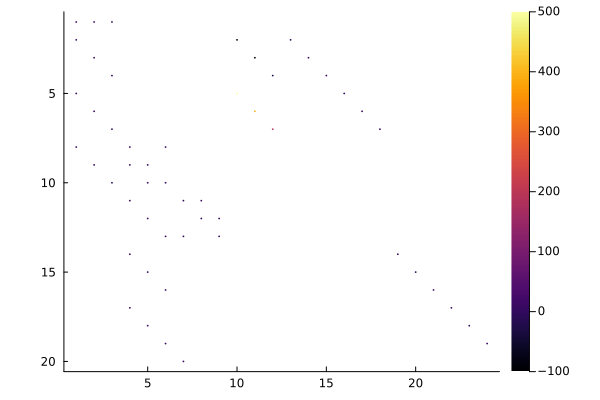

In [16]:
spy(A)